## Double-DQN
#### |问题：DQN过高估计
$
\omega^{*}=\arg \min _{\omega} \frac{1}{2 N} \sum_{i=1}^{N}\left[Q_{\omega}\left(s_{i}, a_{i}\right)-\left(r_{i}+\gamma \max _{a^{\prime}} Q_{\omega}^-\left(s_{i}^{\prime}, a^{\prime}\right)\right)\right]^{2}
$
普通的 DQN 算法通常会导致对Q值的过高估计(overestimation)，因为可以把TD误差目标换一种形式改写：
$$
r_{i}+\gamma \max _{a^{\prime}} Q_{\omega}\left(s_{i}^{\prime}, a^{\prime}\right) \rightarrow r_{i}+\gamma Q_{\omega}^-\left(s_{i}^{\prime}, \arg \max _{a^{\prime}} Q_{\omega^{-}}(s^{\prime}, a^{\prime})\right) 
$$
也就是max操作可以被拆分为两部分：首先$Q_{\omega}^-$选取$s^{\prime}$下的最优动作$a^*$，接着采用$Q_{\omega}^-$算出对应的动作价值
**——两部分采用同一套 Q 网络进行计算时，每次得到的都是神经网络当前估算的所有动作价值中的最大值**

这样在 DQN 的更新方式下神经网络会将正向误差累积，考虑如下情况：在状态$s^{\prime}$所有a的Q=0，正确更新：$r+0=r$，但由于拟合的误差，存在Q>0，导致更新目标被过高估计$r+\gamma \max Q > r+0$
对于动作空间较大的任务，DQN 中的过高估计问题会非常严重，造成 DQN 无法有效工作的后果

---

### 改进：Double DQN 算法
Double DQN 算法提出利用两个独立训练的神经网络估算$\max _{a^{\prime}} Q_{\omega^{-}}\left(s^{\prime}, a^{\prime}\right)$ 更改为$ Q_{\omega^{-}}\left(s^{\prime}, \arg \max _{a^{\prime}} Q_{\omega}\left(s^{\prime}, a^{\prime}\right)\right)$：
——**恰好可以直接将训练网络作为 Double DQN 算法中的第一套神经网络来选取动作，将目标网络作为第二套神经网络计算Q**：
$$
r+\gamma Q_{\omega^{-}}\left(s^{\prime}, \underset{a^{\prime}}{\arg \max } Q_{\omega}\left(s^{\prime}, a^{\prime}\right)\right)
$$

#### |Double DQN关键代码实现:
其实差别非常少，就是原本直接用`.max(1)[0]`获取最大Q，现在改用在`.gather(1,max_action)`的q_net算出的max_action下来获取目标网络Q值：
```python
# 下个状态的最大Q值
if self.dqn_type == 'DoubleDQN' or 'DuelingDQN':  # 先在q网络确定动作, 再对应到目标网络的价值上
    max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
    max_next_q_values = 
    self.target_q_net(next_states).gather(1,max_action)
else:
    max_next_q_values = 
    self.target_q_net(next_states).max(1)[0].view(-1,1)
```

## Dueling DQN
#### |问题：只更新特定动作的Q，其他动作Q不会更新
“为什么 Dueling DQN 会比 DQN 好？”部分原因在于 Dueling DQN 能更高效学习状态价值函数?
传统的 DQN 只会更新某个动作Q的值，其他动作的Q值就不会更新。
而Dueling DQN每一次更新时，函数V都会被更新，这也会影响到其他动作的Q值。因此，Dueling DQN 能够更加频繁、准确地学习状态价值函数。
> DQN 将每个状态-动作对的 Q 值作为一个单一的数值来估计。这意味着它可能会混淆状态的价值与在该状态下采取特定动作的优势。Dueling DQN 通过分解 Q 值为状态价值和动作优势来解决这个问题，从而更精确地估计 Q 值。

---

### 改进：Dueling DQN算法
在强化学习中，我们将状态动作价值函数Q减去状态价值V函数的结果定义为优势函数A，即$A(s,a)=Q(s,a)-V(s)$，在同一个状态下，所有动作的优势值之和为 0。
据此，在 Dueling DQN 中，Q 网络被建模为：
$$
Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a)
$$
$V_{\eta, \alpha}(s)$为状态价值函数，$A_{\eta, \beta}(s, a)$为该状态心爱采取不同动作的优势函数(表示采取不同动作的差异性)，$\eta$是状态价值函数和优势函数共享的网络参数，一般用在神经网络中，用来提取特征的前几层;而$\alpha \beta$分贝为神经网络最后几层的分支
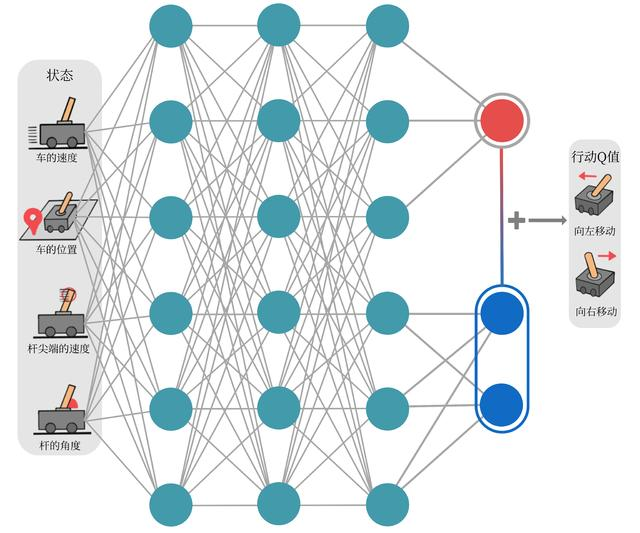

---

### 改进：V值A值建模不唯一问题
对于公式$Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a)$，可能会出现无穷多个函数(V+C,A-C仍然值不变)，这就导致了训练的不稳定性。
为了解决这一问题，Dueling DQN 强制最优动作的优势函数的实际输出为 0，即：
$$
Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a)-\max _{a^{\prime}} A_{\eta, \beta}\left(s, a^{\prime}\right)
$$
此时 $V(s)=\max _{a} Q(s, a)$ 可以确保 V 值建模的唯一性。在实现过程中，我们还可以用平均代替最大化操作，即:
$$
Q_{\eta, \alpha, \beta}(s, a)=V_{\eta, \alpha}(s)+A_{\eta, \beta}(s, a)-\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} A_{\eta, \beta}\left(s, a^{\prime}\right)
$$
此时$V(s)=\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} Q\left(s, a^{\prime}\right)$不再满足贝尔曼最优方式，但是实际应用时更加稳定。

---

#### |Dueling DQN关键代码实现：
分别输出状态价值函数和优势函数，再求和得到值：
```python
class VAnet(torch.nn.Module):
''' 只有一层隐藏层的A网络和V网络 '''
def __init__(self, state_dim, hidden_dim, action_dim):
    super(VAnet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
    self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_V = torch.nn.Linear(hidden_dim, 1)

def forward(self, x):
    x = F.relu(self.fc1(x))
    A = self.fc_A(x)
    V = self.fc_V(x)
    Q = V + A - A.mean(-1).view(-1, 1)  # Q值由V值和A值计算得到
    return Q
```
---

#### |将状态价值函数和优势函数分别建模的好处
某些情境下智能体只会关注状态的价值，而并不关心不同动作导致的差异。
**此时将二者分开建模能够使智能体更好地处理与动作关联较小的状态**
当智能体前面没有车时，车辆自身动作并没有太大差异，此时智能体更关注状态价值，而当智能体前面有车时（智能体需要超车），智能体开始关注不同动作优势值的差异。


---

### 代码实现：
为了确保env唯一，且便于理解，不使用新环境倒立摆，这一章改进的东西直接在上一章节中修改：
设置了self.dqn_type属性，可以在In[6]直接修改这个'DuelingDQN'来实现差异化对比
In[6]:
```python
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update,device,'DuelingDQN')
```
